In [1]:
import torch
import sys
sys.path.extend(['..'])
from mvn import MVNIso, create_mog
from distributions import log_prob_mix_laplace as log_p
from util import acf, ess, estimate_log_z
from math import log, pi, sqrt, exp
import matplotlib.pyplot as plt
import time
from tqdm.notebook import trange
import numpy as np
from scipy.integrate import quad
from samplers.mcmc import HMC
from pathlib import Path
%matplotlib inline

sd = 2479108
torch.manual_seed(sd)
np.random.seed(sd)

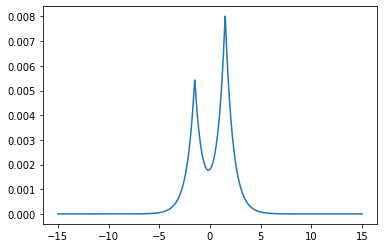

In [2]:
x_grid = torch.linspace(-15, 15, 1500)
discrete_log_p = log_p(x_grid)
discrete_log_p = discrete_log_p - torch.logsumexp(discrete_log_p.flatten(),dim=0)
discrete_p = torch.exp(discrete_log_p)
discrete_p = discrete_p / discrete_p.sum()

plt.plot(x_grid, discrete_p)
plt.show()

## Define a random polynomial

10th order.

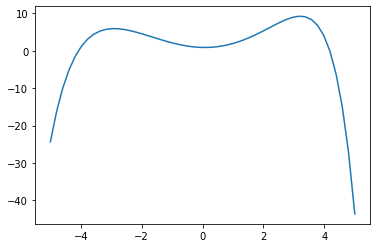

In [3]:
random_coeffs = torch.randn(10) / np.array([np.math.factorial(n) for n in range(10)])
random_poly = np.polynomial.polynomial.Polynomial(random_coeffs)
random_poly
plt.plot(np.linspace(-5,5), random_poly(np.linspace(-5,5)))

Compute the actual expectation under $p^*(x)$ for bias calculations. Use quadrature.

In [4]:
random_poly_expectation, error_est = quad(lambda x: log_p(x*torch.ones(1)).exp() * random_poly(x),
                              -np.inf,
                               np.inf,
                               limit=1000)
random_poly_expectation, error_est

/var/folders/ph/lx9dyyx91893rxnlw09n7t0c0000gn/T/ipykernel_22709/3250965410.py:1: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  random_poly_expectation, error_est = quad(lambda x: log_p(x*torch.ones(1)).exp() * random_poly(x),


(2.279884138540277, 7.365617440914143e-07)

Compute the expectation under $q(x;\theta^*)$, i.e. the best variational approximation

In [5]:
q_vi = MVNIso.new_random(d=1)
q_vi.theta.requires_grad_(True)
theta_vals = torch.zeros(1000, q_vi.n_params)
theta_vals[0, :] = q_vi.theta.detach()
kl_vals = torch.zeros(1000)
for step in range(1, 1000):
    kl_qp = -q_vi.entropy() - q_vi.quadrature_ev(log_p, n=25)
    grad_kl_qp = torch.autograd.grad(kl_qp, q_vi.theta)[0]
    with torch.no_grad():
        kl_vals[step] = kl_qp.detach()
        grad_norm = torch.sqrt(torch.einsum('i,ij,j->', grad_kl_qp, q_vi.fisher(), grad_kl_qp))
        lr = .1 / (1 + step // 100)
        theta_vals[step, :] = theta_vals[step-1, :] - lr * grad_kl_qp / grad_norm
        q_vi.set_theta(theta_vals[step, :])
q_vi.theta.requires_grad_(False)

q_vi_expectation = q_vi.quadrature_ev(random_poly, n=10)

# fig, ax = plt.subplots(1,2,figsize=(6,3))
# ax[0].plot(kl_vals)
# ax[1].plot(theta_vals)

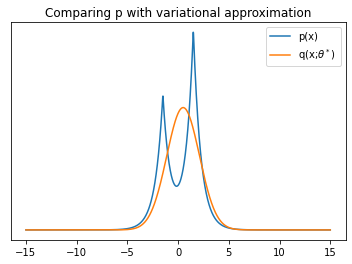

In [6]:
discrete_q_vi = q_vi.to_torch_mvn().log_prob(x_grid[:,None]).exp()
discrete_q_vi = discrete_q_vi / discrete_q_vi.sum()
plt.plot(x_grid, discrete_p)
plt.plot(x_grid, discrete_q_vi)
plt.legend(['p(x)', r'q(x;$\theta^*$)'])
plt.yticks([])
plt.title('Comparing p with variational approximation')
plt.show()

### Define samplers to draw $\theta \sim \psi(\theta)$ for each value of $\lambda$

In [7]:
def log_psi(lam, q):
    kl_qp = -q.entropy() - q.quadrature_ev(log_p, n=25)
    return 0.5*q.log_det_fisher() - lam * kl_qp


def sample_theta(lam, n=1000):
    q = MVNIso(d=1)
    hmc = HMC(lambda th: log_psi(lam, q.set_theta(th)), leapfrog_t=2.)
    
    hmc.tune(torch.randn(200, q.n_params))
    print(f"[lam={lam}]\tmass={hmc.mass.numpy()}\tdt={hmc.dt.item():.4f}")
    return hmc.sample(torch.randn(q.n_params), n, progbar=True)

### Quick sanity-check with $\lambda=2.$

In [ ]:
# %%prun
result = sample_theta(lam=2., n=500)

/Users/richard/Research/parametric-sampling/code-clean/notebooks/../samplers/base.py:40: UserWarning: Encountered non-convex region after switching to newton!
  warn("Encountered non-convex region after switching to newton!")


In [ ]:
# Plot 1: sample traces
plt.plot(result['samples'])
plt.title(f"Samples with $\lambda=2$\nESS={ess(result['samples']).numpy()}")
plt.show()

# Plot 2: mixture density
m = create_mog(MVNIso(theta=th) for th in result['samples'])
discrete_log_m = m.log_prob(x_grid[:,None])
discrete_m = (discrete_log_m - torch.logsumexp(discrete_log_m, dim=0)).exp()
plt.plot(x_grid, discrete_p)
plt.plot(x_grid, discrete_q_vi)
plt.plot(x_grid, discrete_m)
plt.legend(['p(x)', r'q(x;$\theta^*$)', 'm(x)'])
plt.yticks([])
plt.show()

### Run a long sampling chain once per $\lambda$

In [ ]:
lambdas = torch.logspace(0,2,10)
hmc_results = []
for l in lambdas:
    save_file = Path('results') / f"{log_p.__name__}_hmc_lam={l:.3f}.dat"
    if save_file.exists():
        res = torch.load(save_file)
    else:
        res = sample_theta(l, n=10000)
        torch.save(res, save_file)
    hmc_results.append(res)
    print(f"\tfinished lam={l:.3f}, ESS={ess(res['samples']).numpy()}")

### Calculate 'asymptotic' bias by computing expected value random polynomial for every value of the chain

In [ ]:
q = MVNIso(d=1)
full_chain_expectations = torch.zeros(len(lambdas))
for i, r in enumerate(hmc_results):
    component_evs = [q.set_theta(th).quadrature_ev(random_poly, n=10) for th in r['samples']]
    full_chain_expectations[i] = torch.tensor(component_evs).mean()

### Calculate variance by subsampling each chain down to 100 samples many times

In [ ]:
n_subsample, n_run = 100, 50
q = MVNIso(d=1)
subsample_expectations = torch.zeros(len(lambdas), n_run)
for i, r in enumerate(hmc_results):
    for j in range(n_run):
        subset_samples = r['samples'][torch.randint(r['samples'].size(0), (n_subsample,)), :]
        component_evs = [q.set_theta(th).quadrature_ev(random_poly, n=10) for th in r['samples']]
        subsample_expectations[i, j] = torch.tensor(component_evs).mean()

est_variance = torch.mean((subsample_expectations - full_chain_expectations[:, None])**2)

### Plot EVs

In [ ]:
plt.semilogx(lambdas, full_chain_expectations, '-o')
plt.hlines(random_poly_expectation, 1,100,color='r')
plt.hlines(q_vi_expectation, 1,100,color='k')
plt.xlabel("$\lambda$");
plt.ylabel("EV")
plt.legend(['$m_\lambda(x)$', 'true value', 'VI EV')
plt.show()

### Plot bias$^2$ and variance

In [ ]:
bias2 = (full_chain_expectations - random_poly_expectation)**2
mse = bias2 + est_variance

plt.semilogx(lambdas, bias2, '-b', marker='.')
plt.semilogx(lambdas, est_variance, '-r', marker='.')
plt.semilogx(lambdas, mse, '-g', marker='.')
plt.xlabel("$\lambda$");
plt.legend(['bias$^2$', 'variance', 'MSE'])
plt.show()